# Conversion rate challenge

For the sake of completeness, we will implement all the classification methods seen in the course, even those which seem less relevant.

Contents
--------
1. [Data loading and preprocessing](#loading)
2. [Preliminary EDA](#eda)
    1. Utilities
    2. Some tables
    3. Conversion probability heatmap
    4. Influence of visitors' age
    5. Influence of the number of pages visited
    6. Effect of the number of pages visited for each country
    7. Effect of the number of pages visited for each source
    8. Combined effect of age and number of pages visited
    9. Summary # TODO
3. [Utilities](#utils)
3. [Logistic regression](#logreg)
    1. A first model
    2. Adjusting the decision threshold
    3. Receiver operating charcteristic (ROC) curve
    4. Model interpretation
    5. Adding polynomial features
    6. Splitting the model
4. [Linear discriminant analysis](#lda)
    1. Full model
    2. Full model with polynomial features
    3. Split model
5. [Decision trees](#tree)
    1. Full model
    2. Split model
6. [Support vector machines](#svm)
    1. Full model
    2. Split model
7. [Multi-layer perceptron](#mlp)
    1. Full model
    2. Split model
8. [Random forests](#rf)
    1. Full model
    2. Split model
9. [Gradient boosting](#gb)
    1. Full model
    2. Split model
9. [Composite models](#composite)
    1. Voting classifier
    2. Mixing models
8. [Conclusion and perspectives](#conclusion)

In [1]:
import time

import numpy as np
import pandas as pd

## <a id="loading"></a> Data loading and preprocessing

A few remarks on this dataset are in order before proceeding:
- Although gathering data about `'country'`, `'source'`, `'total_pages_visited'` would be easy by monitoring server activity, this is not the case for the `'age'`. This is a hint that the dataset is somewhat artificial.
- Before being a recurring user, a user should have been a `'new_user'` at some point. This raises the question of whether a given user could have been included multiple times in the dataset until they subscribe (or not) to the newsletter.
- Only 4 countries are considered here, which is unlikely for a website. 

In the analysis provided next, we ignore all these issues and assume the dataset honest, without any user selection bias.

In [2]:
df = pd.read_csv('./conversion_data_train.csv')
df

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0
...,...,...,...,...,...,...
284575,US,36,1,Ads,1,0
284576,US,31,1,Seo,2,0
284577,US,41,1,Seo,5,0
284578,US,31,1,Direct,4,0


In [3]:
df.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


There are 284 520 observations, with no missing data. Most feature observations are consistent with what could be expected, except for the `'age'` which has a maximal value of 123. This is larger than the age of the oldest person ever verified. Let us explore if we have other outliers.

In [4]:
df.loc[df['age'] > 70]

,country,age,new_user,source,total_pages_visited,converted
11331,UK,111,0,Ads,10,1
104541,US,72,1,Direct,4,0
175251,US,73,1,Seo,5,0
230590,US,79,1,Direct,1,0
233196,Germany,123,0,Seo,15,1
268311,US,77,0,Direct,4,0


There is a 32-year age gap between 79 and 111, with 2 website visitors older than 80 years old. We choose to remove those 2 records from the dataset.

In [5]:
df = df.loc[df['age'] < 80]
df.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284578,284578.000000,284578.000000,284578,284578.000000,284578.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139476,NaN,NaN
mean,NaN,30.563596,0.685457,NaN,4.873198,0.032251
std,NaN,8.263627,0.464334,NaN,3.341939,0.176667
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


## <a id="eda"></a>Preliminary EDA

We begin with a preliminary data analysis. Our problem is of low dimension, with only 5 predictive features and a binary categorical variable as the target. A good approach in this case is to plot the average of the target as a function of all features. Here this average can be interpreted naturally as the probability of subscription to the newsletter. As we'll see, the insights gathered in this first step will point us towards more advanced data analysis.


### Utilities

Before moving to the data exploration proper, we set-up a few utility functions to wrap around repetitive code:
- `prob_distrib` computes the newsletter subscription probability as a function of the selected variables.
- `prob_distrib_plot` produces a plot of the probability density of the selected variable and the corresponding subscription probability.

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit


def prob_distrib(df: pd.DataFrame,
                 group_by: str,
                 variables: list[str],
                 xvals: list[np.ndarray],
                 ) -> tuple[list, np.ndarray, np.ndarray, np.ndarray]:
    """
    For each element in the `group_by` column, compute the conversion
    probability and a std deviation estimate as a function of the values in the
    columns in `variables`.
    xvals[i] contains an array of values taken by df[variables[i]].
    
    Returns
    -------
    group_vals : list
        The different elements in the `group_by` column of the dataframe.
    counts : np.ndarray of shape (ngroups,) + (len(x) for x in xvals)
        counts[k, i0, .., in] is the number of rows in the k-th group dataframe
        with variables values xvals[0][i0], ..., xvals[n][in]
    pconv : np.ndarray, same shape as `counts`
        The conversion probability (mean of column 'converted'). The value is
        NaN when the corresponding counts are zero.
    std_pconv : np.ndarray, same shape as `pconv`
        An estimate of the std deviation of pconv: p(1-p)/sqrt(n).

    """
    group_vals = []
    counts = np.zeros((df[group_by].nunique(),) + tuple(len(x) for x in xvals),
                      dtype=int)
    pconv = np.full((df[group_by].nunique(),) + tuple(len(x) for x in xvals),
                    np.nan, dtype=float)

    indices = [{x: i for i, x in enumerate(xs)} for xs in xvals] # manage the case of non-integer indices
    for k, (group, gdf) in enumerate(df.groupby(group_by)):
        group_vals.append(group)
        for idx, c in gdf.loc[:, variables].value_counts().items():
            idx = tuple(indice[i] for indice, i in zip(indices, idx))
            counts[k, *idx] = c
        pconv_df = gdf.loc[:, variables + ['converted']] \
                      .groupby(variables) \
                      .mean()['converted']
        for idx, p in pconv_df.items():
            idx = idx if isinstance(idx, tuple) else (idx,)  # cast to tuple if no multiindex
            idx = tuple(indice[i] for indice, i in zip(indices, idx))
            pconv[k, *idx] = p

    std_pconv = np.where(pconv * (1 - pconv) == 0., 1, pconv) / np.sqrt(counts)
    return group_vals, counts, pconv, std_pconv


def prob_distrib_plot(xvals: np.ndarray,
                      counts: np.ndarray,
                      pconv: np.ndarray,
                      std_pconv: np.ndarray,
                      group_labels: list[str]):
    """
    Make two plots:
    Left: using `counts`, plot the probablity density of the selected variable
          for each group.
    Right: using `pconv` and `std_pconv`, plot the conversion probability vs
           selected variable for each group.

    Parameters
    ----------
    xvals : 1D np.ndarray
        The values taken by the selected variable.
    counts, pconv, std_pconv : 2D np.ndarray, shape (ngroups, len(xvals))
        arr[i, j] = relevant quantity for group i, at xvals[j].
    group_labels : list[str]
        The group labels.

    Returns
    -------
    fig , axs: matplotlib Figure, np.ndarray[matplotlib Axes], shape (2,)
        The figure and axes, for further processing.

    """
    fig, axs = plt.subplots(
        nrows=1, ncols=2, figsize=(9, 4),
        gridspec_kw={'left': 0.08, 'right': 0.96, 'top': 0.85, 'bottom': 0.12})

    axs[0].grid(visible=True, linewidth=0.3)
    distribs = counts / np.sum(counts, axis=1, keepdims=True)
    for k, label in enumerate(group_labels):
        axs[0].plot(xvals, distribs[k], color=f'C{k}',
                    linewidth=1, label=f'{label} ({int(np.sum(counts[k]))})')
    axs[0].set_xlim(0, np.max(xvals)+1)
    axs[0].set_ylim(-0.0005, (int(np.max(distribs)*100)+1)/100)
    axs[0].set_ylabel('Prob. density')

    axs[1].grid(visible=True, linewidth=0.3)
    for k, label in enumerate(group_labels):
        axs[1].errorbar(xvals, pconv[k], yerr=std_pconv[k],
                        color=f'C{k}', fmt='o', markersize=3, markeredgewidth=0.3,
                        label=label)
    axs[1].set_xlim(0, np.max(xvals)+1)
    axs[1].set_ylim(-0.005, int(np.max(pconv[~np.isnan(pconv)])*120)/100)
    axs[1].set_title("Conversion probability")
    axs[1].set_ylabel('Conversion probability')

    return fig, axs

### Some tables

We begin by counting the conversion events vs the various categorical variables, `'country'`, `'new_user'`, `'source'`.

In [7]:
df.groupby(['country', 'converted']).count()['age'] # the name 'age' is irrelevant here

country  converted
China    0             69033
         1                89
Germany  0             10963
         1               729
UK       0             41350
         1              2290
US       0            154054
         1              6070
Name: age, dtype: int64

In [8]:
df.groupby(['source', 'converted']).count()['age']

source  converted
Ads     0             77242
        1              2784
Direct  0             63266
        1              1810
Seo     0            134892
        1              4584
Name: age, dtype: int64

In [9]:
df.groupby(['source', 'converted']).count()['age']

source  converted
Ads     0             77242
        1              2784
Direct  0             63266
        1              1810
Seo     0            134892
        1              4584
Name: age, dtype: int64

The conversion events are rather rare, with a global rate of 3.2%, 1% for new website visitors and 8% for recurrent visitors. Although the subscription probability is rather homogeneous accross the various sources, this is not the case for the different countries. In particular, the conversion events are very rare among chinese visitors, with a count of only 89. We anticipate that this will cause a lot of variance in classifying new events corresponding to chinese visitors.

### Conversion probability heatmap

We make the above observation more visual by showing heatmaps of the newsletter subscription probabilility for the categorical features `'source'` and `'country'`, for both recurring (left) and new (right) visitors. We also indicate the conversion probability (in %) the total counts corresponding to each condition.

In [10]:
sources = ['Ads', 'Direct', 'Seo']
countries = ['China', 'Germany', 'UK', 'US']
new_user, counts, pconv, _ = prob_distrib(
    df, group_by='new_user', variables=['source', 'country'],
    xvals=[sources, countries])

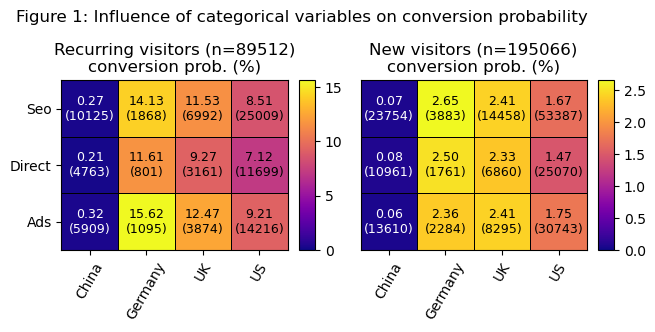

In [11]:
fig1, axs1 = plt.subplots(
    nrows=1, ncols=2, figsize=(6.5, 3.2),
    gridspec_kw={'left': 0.09, 'right': 0.94, 'top': 0.88, 'bottom': 0.11, 'wspace': 0.18})
fig1.suptitle('Figure 1: Influence of categorical variables on conversion probability', x=0.02, ha='left')

axs1_cb = np.empty_like(axs1, dtype=object)
for k, ax in enumerate(axs1):
    ax.set_aspect('equal')
    heatmap = ax.pcolormesh(100*pconv[k], cmap='plasma', vmin=0,
                            edgecolors='k', lw=0.5)
    ax.set_xticks([0.5, 1.5, 2.5, 3.5], countries, rotation=60)
    ax.set_yticks([0.5, 1.5, 2.5], sources)
    for (i, j), p in np.ndenumerate(pconv[k]):
        color = 'k' if p > np.max(pconv[k]) / 3 else 'w'
        ax.text(j+0.5, i+0.5, f'{100*p:.2f}\n({counts[k, i, j]})',
                fontsize=9, color=color, ha='center', va='center')
    
    div = make_axes_locatable(ax)
    axs1_cb[k] = div.append_axes("right", size="7%", pad="5%")
    fig1.add_axes(axs1_cb[k])
    fig1.colorbar(heatmap, cax=axs1_cb[k], orientation="vertical", ticklocation="right")

axs1[0].set_title(f"Recurring visitors (n={np.sum(counts[0])})\nconversion prob. (%)")
axs1_cb[0].set_yticks([0, 5, 10, 15])

axs1[1].set_title(f"New visitors (n={np.sum(counts[1])})\nconversion prob. (%)")
axs1[1].tick_params(left=False, labelleft=False)
axs1_cb[1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5])

plt.show()

We note the following trends, that could already been seen from the raw data in the tables above:
- Recurring visitors are 2.5 - 8 times more likely to subscribe to the newsletter.
- Chinese visitors are much less likely to subscribe than others despite being the second population in terms of country.
- The way by which visitors reached the website has little impact on their eventual subscription.

We anticipate that the very low conversion probability among chinese users will cause a lot of variance in the classification of new visits from China.

### Influence of visitors' age on the conversion probability

We turn to the study of the impact of quantitative variables on the conversion probability, begining with the variable `'age'`. We have seen before that there is a strong dependence in user status (new or recurring), we consider the two types of users separately.

In [12]:
ages = np.arange(80)
new_user, age_counts, age_pconv, age_std_pconv = prob_distrib(
    df, group_by='new_user', variables=['age'], xvals=[ages])

In [13]:
# fit decqying exponential
def decay_exp(x: np.ndarray,
              A: float,
              tau: float) -> np.ndarray:
    """
    Exponential decay: f(x) = A * exp(- x / tau)
    """
    return A * np.exp(- x / tau)

idx = ~np.isnan(age_pconv)
popt, pcov = [], []
for k, i in enumerate(idx):
    popt_, pcov_ = curve_fit(decay_exp, ages[i], age_pconv[k, i], p0=(0.1, 10),
                             sigma=age_std_pconv[k, i])
    popt.append(popt_)
    pcov.append(pcov_)

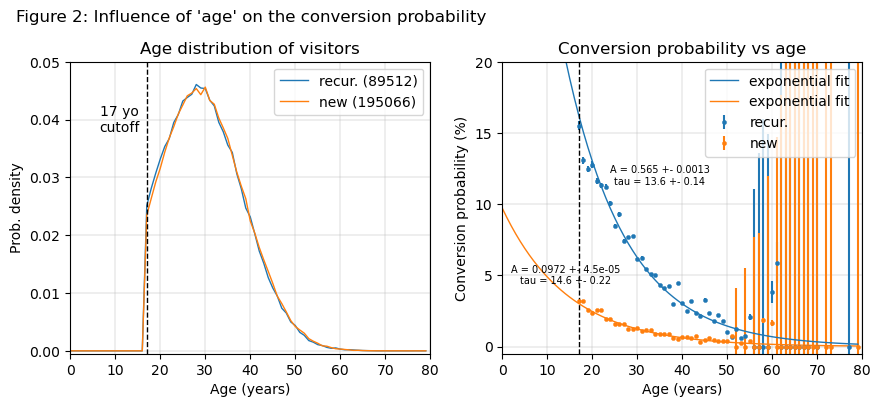

In [14]:
fig2, axs2 = prob_distrib_plot(
    ages, age_counts, age_pconv, age_std_pconv,
    group_labels=['recur.', 'new'])
fig2.suptitle("Figure 2: Influence of 'age' on the conversion probability", x=0.02, ha='left')

axs2[0].axvline(17, color='k', linewidth=1, linestyle='--')
axs2[0].text(11, 0.04, '17 yo\ncutoff', ha='center', va='center')
axs2[0].set_title("Age distribution of visitors")
axs2[0].set_xlabel('Age (years)')
axs2[0].legend(loc=1)

for k, popt_ in enumerate(popt):
    axs2[1].plot(ages, decay_exp(ages, *popt_),
                 linewidth=1, color=f'C{k}', label='exponential fit')
popt_txt = [f'A = {popt_[0]:.3} +- {pcov_[0, 0]:.2}\ntau = {popt_[1]:.3} +- {pcov_[1, 1]:.2}'
            for popt_, pcov_ in zip(popt, pcov)]
axs2[1].text(35, 0.12, popt_txt[0], ha='center', va='center', fontsize=7)
axs2[1].text(14, 0.05, popt_txt[1], ha='center', va='center', fontsize=7)
axs2[1].axvline(17, color='k', linewidth=1, linestyle='--')
axs2[1].set_yticks([0, 0.05, 0.1, 0.15, 0.2], [0, 5, 10, 15, 20])
axs2[1].set_ylabel('Conversion probability (%)')
axs2[1].set_title("Conversion probability vs age")
axs2[1].set_xlabel('Age (years)')
axs2[1].legend()

plt.show()

We show in figure 2 the distribution of ages (left panel) and the conversion probability (right panel) aggregated by `'source'` and `'country'`, but distinguishing new and recurrent visitors.
- The distribution of ages is the same for the two categories: a truncated gaussian with a cutoff at 17 years old, centered at around 28 years old. The probability of having a new visitor is thus roughly twice that of a recurrent visitor, independently of age.
- The newsletter subscription probability decays with age. The observed decay fits well with an exponential from which we get similar decay constants of about 14 years. We also recover the ratio of 5-6 of conversion probability between recurrent and new visitors.

Finally, we note that these patterns are extremely regular and again reveal the artificial nature of the data.

### Influence of the number of pages visited

We proceed in a similar fashion this time with the quantity `'total_pages_visited'`.

In [15]:
npages = np.arange(30)
new_user, usr_npage_counts, usr_npage_pconv, usr_npage_std_pconv = prob_distrib(
    df, group_by='new_user', variables=['total_pages_visited'], xvals=[npages])

In [16]:
# sigmoid fit
def sigmoid(x: np.ndarray,
            x0: float,
            a: float) -> np.ndarray:
    """
    Exponential decay: f(x) = 1 / (1 + exp(- a * (x - x0)))
    """
    return 1 / (1 + np.exp(- a * (x - x0)))


idx = ~np.isnan(usr_npage_pconv)
usr_popt, usr_pcov = [], []
for k, i in enumerate(idx):
    popt_, pcov_ = curve_fit(sigmoid, npages[i], usr_npage_pconv[k, i], p0=(15, 1))
    usr_popt.append(popt_)
    usr_pcov.append(pcov_)

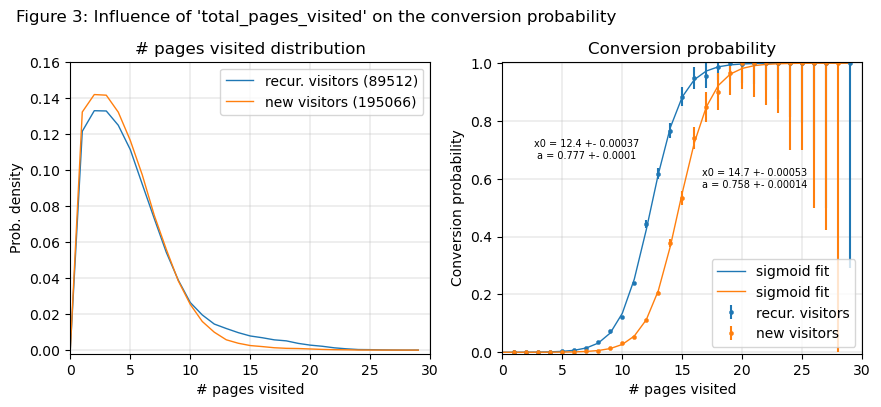

In [17]:
fig3, axs3 = prob_distrib_plot(
    npages, usr_npage_counts, usr_npage_pconv, usr_npage_std_pconv,
    group_labels=['recur. visitors', 'new visitors'])
fig3.suptitle("Figure 3: Influence of 'total_pages_visited' on the conversion probability",
              x=0.02, ha='left')

axs3[0].set_ylim(-0.002, 0.16)
axs3[0].set_title("# pages visited distribution")
axs3[0].set_xlabel('# pages visited')
axs3[0].legend()


for k, popt_ in enumerate(usr_popt):
    axs3[1].plot(npages, sigmoid(npages, *popt_),
                 linewidth=1, color=f'C{k}', label='sigmoid fit')

popt_txt = [f'x0 = {popt_[0]:.3} +- {pcov_[0, 0]:.2}\na = {popt_[1]:.3} +- {pcov_[1, 1]:.2}'
            for popt_, pcov_ in zip(usr_popt, usr_pcov)]
axs3[1].text(7, 0.7, popt_txt[0], ha='center', va='center', fontsize=7)
axs3[1].text(21, 0.6, popt_txt[1], ha='center', va='center', fontsize=7)

axs3[1].set_xlim(0, 30)
axs3[1].set_ylim(-0.005, 1.005)
axs3[1].set_title("Conversion probability")
axs3[1].set_xlabel('# pages visited')
axs3[1].set_ylabel('Conversion probability')
axs3[1].legend()

plt.show()

The number of pages visited is clearly the most relevant feature that determines the newsletter subscription, with a sigmoid dependence of the conversion probability.
- The effect of the number of pages visited takes the form of an "activation threshold" dependent on the visitor status. Fitting with a sigmoid function gives an inflection point of about 12.4 for recurring users and 14.7 for new users, with a similar slope for both.
- The distributions of number of pages visited are not proportional. In particular, those visits which contribute the most to the newsletter subscription are less likely among new visitors. Together with the higher conversion threshold, this explains the significantly lower conversion rate of new visitors.

We again stress that such regularity is unlikely in any realistic context.

### Effect of the number of pages visited for each country

We noted above that the country of origin has a significant impact on the conversion probability. We explore here the dependence of the conversion probability in the number of pages visited for each country instead of user status.

In [18]:
npages = np.arange(30)
country, ctry_npage_counts, ctry_npage_pconv, ctry_npage_std_pconv = prob_distrib(
    df, group_by='country', variables=['total_pages_visited'], xvals=[npages])

In [19]:
# sigmoid fit
idx = ~np.isnan(ctry_npage_pconv)
ctry_popt, ctry_pcov = [], []
for k, i in enumerate(idx):
    popt_, pcov_ = curve_fit(sigmoid, npages[i], ctry_npage_pconv[k, i], p0=(15, 1))
    ctry_popt.append(popt_)
    ctry_pcov.append(pcov_)

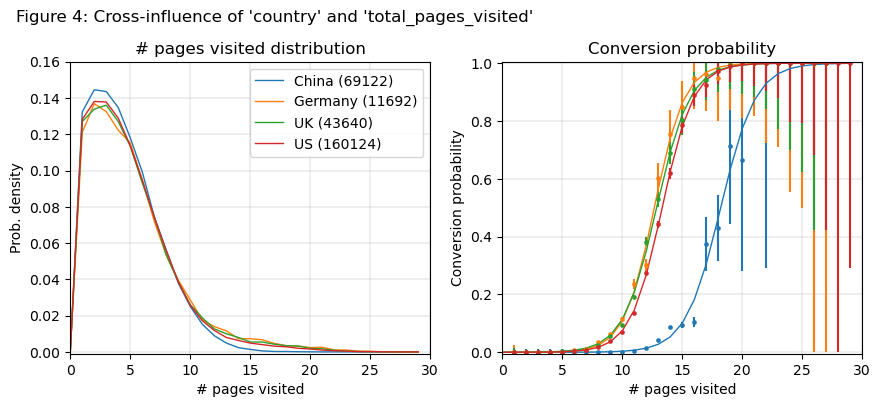

In [20]:
fig4, axs4 = prob_distrib_plot(
    npages, ctry_npage_counts, ctry_npage_pconv, ctry_npage_std_pconv,
    group_labels=country)
fig4.suptitle("Figure 4: Cross-influence of 'country' and 'total_pages_visited'", x=0.02, ha='left')

axs4[0].set_ylim(-0.001, 0.16)
axs4[0].set_title("# pages visited distribution")
axs4[0].set_xlabel('# pages visited')
axs4[0].legend(loc=1)

for k, popt_ in enumerate(ctry_popt):
    axs4[1].plot(npages, sigmoid(npages, *popt_),
                 linewidth=1, color=f'C{k}', label='sigmoid fit')
axs4[1].set_ylim(-0.005, 1.005)
axs4[1].set_xlabel('# pages visited')

plt.show()

Figure 4 shows, for each country of origin, the distribution of pages visited (left panel) and the conversion probability as a function of the number of pages visited (right panel).
- The behavior of users from `'Germany'`, `'UK'` and `'US'` is quite similar both in terms of page visits and conversion probability thresholding with a tendency Germany < UK < US matching the differences observed in figure 1.
- The behavior difference of users from `'China'` is striking. First, the distibution of pages visits is different, with much less visits of more than 13 pages, those which are associated to newsletter subscription. Second, the threshold seems to be set at a significantly higher level than other countries. These two factors contribute to the much lower conversion rates observed in figure 1.

### Effect of the number of pages visited for each source

For the sake of completeness, we produce the same plot as before, this time with the variable `'source'`. We did not observe a significant impact of this feature in figure 1, and we do not expect any significant differences between the various curves. 

In [21]:
npages = np.arange(30)
source, npage_counts, npage_pconv, npage_std_pconv = prob_distrib(
    df, group_by='source', variables=['total_pages_visited'], xvals=[npages])

In [22]:
# sigmoid fit
idx = ~np.isnan(npage_pconv)
popt, pcov = [], []
for k, i in enumerate(idx):
    popt_, pcov_ = curve_fit(sigmoid, npages[i], npage_pconv[k, i], p0=(15, 1))
    popt.append(popt_)
    pcov.append(pcov_)

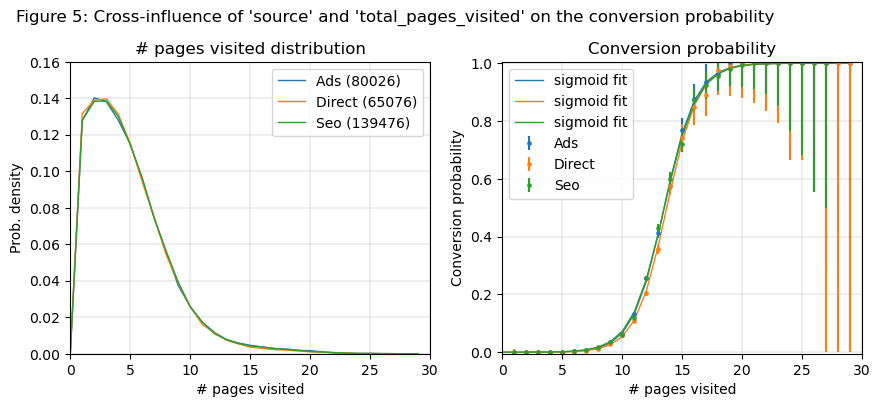

In [23]:
fig5, axs5 = prob_distrib_plot(
    npages, npage_counts, npage_pconv, npage_std_pconv,
    group_labels=source)
fig5.suptitle("Figure 5: Cross-influence of 'source' and 'total_pages_visited' on the conversion probability",
              x=0.02, ha='left')

axs5[0].set_ylim(0, 0.16)
axs5[0].set_title("# pages visited distribution")
axs5[0].set_xlabel('# pages visited')
axs5[0].legend(loc=1)

for k, popt_ in enumerate(popt):
    axs5[1].plot(npages, sigmoid(npages, *popt_),
                 linewidth=1, color=f'C{k}', label='sigmoid fit')
axs5[1].set_ylim(-0.005, 1.005)
axs5[1].set_xlabel('# pages visited')
axs5[1].legend(loc=2)

plt.show()

The distribution of pages visits is the same for each source. The only difference being in the conversion threshold, with a trend following that of figure 1.

### Combined effect of age and number of pages visited

We conclude the EDA by studying the combined effect of the quantitative variables `'age'` and `'total_pages_visited'` on the conversion probability.

In [24]:
ages, npages = np.arange(80), np.arange(30)
new_user, counts, pconv, std_pconv = prob_distrib(
    df, group_by='new_user', variables=['age', 'total_pages_visited'],
    xvals=[ages, npages])

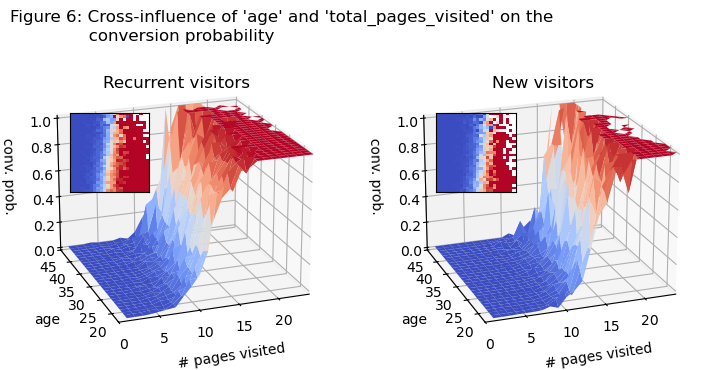

In [25]:
x, y = np.meshgrid(npages[:25], ages[17:46])
xx, yy = np.meshgrid(npages[:26]-0.5, ages[17:47]-0.5)

fig6, axs6 = plt.subplots(
    nrows=1, ncols=2, figsize=(7, 3.8),
    gridspec_kw={'left': 0.04, 'right': 1., 'top': 0.9, 'bottom': 0.02},
    subplot_kw=dict(projection='3d'))
fig6.suptitle("Figure 6: Cross-influence of 'age' and 'total_pages_visited' on the\n               conversion probability",
              x=0.02, ha='left')

for k, label in enumerate(['Recurrent visitors', 'New visitors']):
    axs6[k].view_init(elev=20, azim=-110)
    surf = axs6[k].plot_surface(
        x, y, pconv[k, 17:46, :25], rstride=1, cstride=1, cmap='coolwarm',
        linewidth=0, antialiased=True, shade=False)

    axs6[k].set_xlim(0, 24)
    axs6[k].set_ylim(17, 45)
    axs6[k].tick_params(pad=0)
    axs6[k].set_title(label, y=0.94)
    axs6[k].set_xlabel('# pages visited')
    axs6[k].set_ylabel('age')
    axs6[k].set_zlabel('conv. prob.')
    
    ax6_ins = axs6[k].inset_axes([0.15, 0.55, 0.26, 0.26])
    ax6_ins.pcolormesh(xx, yy, pconv[k, 17:46, :25], cmap='coolwarm', vmin=0, vmax=1)
    ax6_ins.set_xlim(0.5, 24.5)
    ax6_ins.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

plt.show()

The figure shows the conversion probability as a function of age and number of pages visited for both recurring (left panel) and new (right panel) visitors. The insets show the same data as a heatmap, on which the conversion threshold is easily visualized.
- The sigmoid dependence of the conversion probability vs. number of pages visited seems valid over the whole age range.
- In both conditions, the inflection point seems to be *linearly* dependent with the age. The dependence is positive: older visitors subscribe with more page visits.

The boundary separating the conversion outcomes is clearly linear, and we thus expect a linear model to perform very well.

#### Summary

In summary, we gathered the following insights about the dependence of the subscription probability with various features:
- The behavior of website visitors from `'China'` differs significantly with that of users from other countries. A predictive model could completely distinguish the two populations, that is we could make one model trained on data from chinese users and one model with the rest of the data.
- The behavior of website visitors depends significantly on the country and on whether they visit for the first time, but less so of how they reached the website. We could consider building new features $\mathrm{country} \times X$, $\mathrm{new\_ user} \times X$, and even $\mathrm{country} \times \mathrm{new\_ user} \times X$, where $X$ represents any other feature.
- There is an exponential dependence of the subscription probability in the visitors' age, $p_{\mathrm{conv}} \propto \exp(-\mathrm{age} / 14)$. We could consider adding this quantity to the features. However, the exponential looks linear enough on the range explored and this might not be useful.
- The subscription probability has a sigmoid dependence in the number of pages visited. The latter feature is thus clearly the most relevant in predicting the newsletter subscription.
- The last plot showed the inflection point of this sigmoid relationship to be slightly dependent on the age of the visitor. We could thus add the feature product $\mathrm{age} \times \mathrm{total\_ pages\_ visited}$ to the model.

## <a id="utils"></a>Utilities

Before moving on to machine learning proper, we introduce here some utilities and helper functions for the subsequent sections.

In [26]:
from scipy.special import expit, logit

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix,
                             roc_curve,
                             auc)
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold,
                                     TunedThresholdClassifierCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   FunctionTransformer)

The following are convenience functions for displaying metrics, parameter optimization and model evaluation.

In [27]:
def print_metrics(cm: np.ndarray,
                  print_cm: bool = True,
                  print_precrec: bool = True)-> None:
    """
    Print metrics related to the confusion matrix: precision, recall, F1-score.
    """
    t = np.sum(cm, axis=1)[1]
    recall = (cm[1, 1] / t) if t != 0 else 1.
    t = np.sum(cm, axis=0)[1]
    prec = (cm[1, 1] / t) if t != 0 else 1.
    if print_cm:
        print("Confusion matrix\n", cm / np.sum(cm))
    if print_precrec:
        print(f'Precision: {prec:.8}; recall: {recall:.8}')
    print(f'F1-score: {2*prec*recall/(prec+recall):.8}')


def evaluate_model(model,
                   xtest_fname: str = 'conversion_data_test.csv',
                   ytest_fname: str = 'conversion_data_test_labels.csv'
                   )-> tuple[np.ndarray, np.ndarray]:
    """
    Evaluate the model on the test set. The predictions are exported as
    'conversion_data_test_predictions_{name_suffix}.csv'
    """
    X_test = pd.read_csv(xtest_fname)
    y_test = pd.read_csv(ytest_fname)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    
    return y_pred, cm


def cv_eval(model, X: np.ndarray, y: np.ndarray,
            n_splits: int = 10)-> np.ndarray:
    """
    Evaluation of a multi-model by cross-validation.
    Returns the confusion matrix.
    """
    cm = np.zeros((2, 2), dtype=int)  # confusion matrix
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for i, (itr, ival) in enumerate(cv.split(X, y)):
        model.fit(X.iloc[itr], y.iloc[itr])
        cm += confusion_matrix(y.iloc[ival], model.predict(X.iloc[ival]))
    return cm


def gridsearch_cv(model, X: np.ndarray, y: np.ndarray,
                  param_name: str, param_vals: np.ndarray,
                  n_splits: int = 10)-> float:
    """
    Grid search parameter optimization of a model by cross-validation.
    The parameters must be in the 'classifier' step of the model.
    """
    gsearch = GridSearchCV(
        model,  param_grid={f'classifier__{param_name}': param_vals},
        scoring='f1', n_jobs=4, refit=False, cv=n_splits)
    gsearch.fit(X, y)
    best_param = gsearch.best_params_[f'classifier__{param_name}']
    print(f'found best {param_name}: {best_param}')
    return best_param


def tune_threshold_cv(model, X: np.ndarray, y: np.ndarray,
                      n_splits: int = 10,
                      verbose: bool = True):
    """
    Tune the decision threhold of the model to maximize the F1 score by 
    cross-validation.
    """
    model_ta = TunedThresholdClassifierCV(
        model, scoring='f1', cv=n_splits, refit=True, random_state=1234)
    t0 = time.time()
    model_ta.fit(X, y)
    t1 = time.time()
    
    best_thr = model_ta.best_threshold_
    best_score = model_ta.best_score_
    
    if verbose:
        print(f'model fitting time: {t1-t0} s')
        print(f'best threshold = {best_thr:.8f}\nbest F1-score = {best_score:.8f}')
    
    return model_ta

In the upcomming sections, we will split our models into a collection of models adjusted to each categorical variable. The following are utilities designed to work with those composite models.

In [28]:
def split_data(groups: list[str])-> tuple[dict, dict]:
    """
    Split the data as a dict : group_index -> dataframe.
    """
    Xs = {idx: df_.drop(groups, axis=1) for idx, df_ in X.groupby(groups)}
    ys = {idx: y.loc[X_.index] for idx, X_ in Xs.items()}
    return Xs, ys


def multimodel_gridsearch_cv(models: dict, Xs: dict, ys: dict,
                             param_name: str, param_vals: np.ndarray,
                             n_splits: int = 10)-> np.ndarray:
    """
    Grid search parameter optimization of a multi-model by cross-validation.
    The `models`, `Xs` and `ys` are dict : group_index -> model/data.
    
    The parameters must be in the 'classifier' step of the model.
    """
    best_params = {}
    for idx, model in models.items():
        print(f'{idx} :: ', end='')
        best_params[idx] = gridsearch_cv(
            model, Xs[idx], ys[idx], param_name, param_vals, n_splits)
        
    return best_params


def multimodel_cv_eval(models: dict, Xs: dict, ys: dict,
                       n_splits: int = 10,
                       print_partial_scores: bool = False
                       )-> tuple[dict, np.ndarray]:
    """
    Evaluation of a multi-model by cross-validation.
    The `models`, `Xs` and `ys` are dict : group_index -> model/data.
    """
    cms = {}
    for idx, model in models.items():
        X_, y_ = Xs[idx], ys[idx]
        cms[idx] = cv_eval(model, X_, y_, n_splits)
    cm = sum(cm_ for cm_ in cms.values()) # confusion matrix
    
    if print_partial_scores:
        print('===== Partial scores =====')
        for idx, cm_ in cms.items():
            print(f'== index: {idx} ==')
            print_metrics(cm_, print_cm=False)
    print('\n===== Global scores =====')
    print_metrics(cm)
    
    return cms, cm


class MimicEstimator():
    """
    Wrapper around a dict of models providing a `predict` for model evaluation
    on test data.
    """

    def __init__(self, model: dict, groups: list[str]):
        self.groups: list[str] = groups
        self.model: dict = model

    def predict(self, df: pd.DataFrame) -> np.ndarray:
        y_pred = np.empty(len(df), dtype=int)
        Xs = {idx: df_.drop(groups, axis=1)
              for idx, df_ in df.groupby(self.groups)}
        for idx, X in Xs.items():
            y_pred[X.index] = self.model[idx].predict(X)
        return y_pred

## <a id="logreg"></a>Logistic regression

We begin with the simplest classification model, logistic regression. As shown in the EDA section, setting a linear decision boundary will already provide a very good solution to our problem.

In [29]:
from sklearn.linear_model import LogisticRegression

### A first model

We reproduce here the basic linear regression from the template, this time including all the features in the fit. For this first model, we keep things simple and perform all the steps explicitely.


#### Model construction and training

One hot encoding is done with `pandas.get_dummies`. We drop manually the categories with the largest counts: 'country_US' and 'source_Seo'. For model evaluation, we do a simple train-test split using the train set.

In [30]:
# Data to fit
y = df.loc[:, 'converted']
X_df = df.drop('converted', axis=1)

# One-hot encoding with pandas
X_df = pd.get_dummies(X_df)
X = X_df.drop(['country_US', 'source_Seo'], axis=1)

# Simple train-test split
X_tr, X_test, y_tr, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=1234)

# Data scaling: scale everything, including categorical data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)

# fit logistic regression classifier
lr_model = LogisticRegression()
lr_model.fit(X_tr, y_tr)

LogisticRegression()

#### Performance assessment

The retained evaluation metrics for this problem is the F1-score, computed from the confusion matrix.

We get F1-scores of 0.762 for the train set and 0.774 for the test set. These values are produced by about 70% recall and 85% precision. Our model has a tendency to miss conversion events, and in counterpart reduces its false positives rate.

This can be interpreted as an effect of the strong imbalance between outcomes. Non-conversion events occur 30 times more frequently. This causes an imbalance in the loss function penalties from both sides, which in turn tends to repell the decision boundary towards the conversion zone.

In [31]:
print('===== Train set metrics =====')
y_tr_pred = lr_model.predict(X_tr)
print_metrics(confusion_matrix(y_tr, y_tr_pred))

print('\n===== Test set metrics =====')
X_test = scaler.transform(X_test)  # no fit this time
y_test_pred = lr_model.predict(X_test)
print_metrics(confusion_matrix(y_test, y_test_pred))

===== Train set metrics =====
Confusion matrix
 [[0.96397001 0.00377948]
 [0.01005779 0.02219272]]
Precision: 0.85447986; recall: 0.68813559
F1-score: 0.76233906

===== Test set metrics =====
Confusion matrix
 [[0.96394687 0.00379507]
 [0.00948767 0.0227704 ]]
Precision: 0.85714286; recall: 0.70588235
F1-score: 0.77419355


#### Evaluation on test data

We finally evaluate our model on the test data provided. Before doing so, we train on the full dataset.

In [32]:
t0 = time.time()
lr_model.fit(X, y)
t1 = time.time()
print(f'model fitting time: {t1-t0} s')

model fitting time: 0.9920022487640381 s


In [33]:
X_test = pd.read_csv('conversion_data_test.csv')
X_test = pd.get_dummies(X_test)
X_test = X_test.drop(['country_US', 'source_Seo'], axis=1)
y_test = pd.read_csv('conversion_data_test_labels.csv')
y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print('===== Basic logistic regression =====')
print_metrics(cm)

===== Basic logistic regression =====
Confusion matrix
 [[0.96366224 0.0040797 ]
 [0.01024668 0.02201139]]
Precision: 0.84363636; recall: 0.68235294
F1-score: 0.75447154


The real test set F1-score is 0.754, slightly lower than that of the train set, which indicates a (minor) overfitting.

### Adjusting the decision threshold

Let us now make some improvements to the previous code, without changing the model (almost).

#### Model construction

A first improvement is to make it work in a more integrated fashion. We thus do the following:
- The data preprocessing, encoding of categorical variables and scaling of quantitative variables, is wrapped in a `compose.ColumnTransformer`
- The preprocessing and classification are wrapped in a `pipeline.Pipeline`, exposing a single interface for all steps

In the one-hot encoding of categorical variables, we do not set `drop='first'`. This is actually unecessary since the default `LogisticRegression` includes some L2 regularization which prevents the redundancy in the regression coefficients. However, in doing so we retain the symmetry of the model with respect to the various categories, and, in turn, its interpretability.

In [34]:
# data preparation
y = df.loc[:, 'converted']
X = df.drop('converted', axis=1)

# column preprocessing
cat_vars = ['country', 'source']
bool_vars = ['new_user']
quant_vars = ['age', 'total_pages_visited']
col_preproc_full = ColumnTransformer(
    [('cat_ohe', OneHotEncoder(drop=None), cat_vars),
     ('bool_id', FunctionTransformer(feature_names_out='one-to-one'), bool_vars),
     ('quant_scaler', StandardScaler(), quant_vars)])

# full pipeline
pipeline = Pipeline([('column_preprocessing', col_preproc_full),
                     ('classifier', LogisticRegression())])

#### Training

The default logistic regression classifier uses a threshold probability of 0.5 to classify an observation. This corresponds to the minimization of the logistic loss. However, we recall that the performance of our model is assessed not by the average logistic loss but by the F1-score. We can gain further by tuning this decision threshold so as to maximize the F1-score. This is done by wrapping the pipeline into a `model_selection.TunedThresholdClassifierCV`.

In [35]:
lr_model_ta = TunedThresholdClassifierCV(
    pipeline, scoring='f1', cv=10, random_state=1234)

t0 = time.time()
lr_model_ta.fit(X, y)
t1 = time.time()
print(f'model fitting time: {t1-t0} s')

best_thr = lr_model_ta.best_threshold_
best_score = lr_model_ta.best_score_
print(f'best threshold = {best_thr:.8f}',
      f'\nbest F1-score = {best_score:.8f}')

model fitting time: 9.965059041976929 s
best threshold = 0.36363517 
best F1-score = 0.76998796


#### Evaluation on test data

In [36]:
print('\n===== Logistic regression with adjusted decision threshold =====')
_, cm = evaluate_model(lr_model_ta)
print_metrics(cm)


===== Logistic regression with adjusted decision threshold =====
Confusion matrix
 [[0.9612587  0.00648324]
 [0.00850727 0.02375079]]
Precision: 0.78556485; recall: 0.73627451
F1-score: 0.76012146


Compared to that of the non-adjusted linear regression, we get 20% less false negatives, at the expense of 60% more false positives. However, the absolute decrease of false negatives is larger than that of false positives, yielding a slightly better F1 score of 0.76.

### Receiver operating charcteristic (ROC) curve

The receiver operating characteristic curve is the natural metric associated to the classification threshold variation. We produce the mean curve through 10-times cross validation building a ROC curve from each validation set and averaging the results.

In [37]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1234)
clf = clone(pipeline)

mean_cm = np.zeros((2, 2), dtype=float)  # confusion matrix
mean_fpr = np.linspace(0, 1, 401)  # false-positive rates
mean_tpr = np.zeros(401, dtype=float)  # true-positive rates
thr_fpr, thr_tpr = 0, 0  # fpr, tpr at threshold
for i, (itr, ival) in enumerate(cv.split(X, y)):
    X_v, y_v = X.iloc[ival], y.iloc[ival]
    clf.fit(X.iloc[itr], y.iloc[itr])
    # confusion matrix
    y_pred = clf.predict_proba(X_v)[:, 1] > best_thr
    mean_cm += confusion_matrix(y_v, y_pred) / len(X)
    # ROC
    y_decision = clf.decision_function(X_v)
    fpr, tpr, thr = roc_curve(y_v, y_decision)
    mean_tpr += np.interp(mean_fpr, fpr, tpr, left=0, right=1) / n_splits
    thr_fpr += np.interp(best_thr, expit(thr[::-1]), fpr[::-1]) / n_splits
    thr_tpr += np.interp(best_thr, expit(thr[::-1]), tpr[::-1]) / n_splits
mean_tpr[0] = 0
mean_auc = auc(mean_fpr, mean_tpr)

print('===== CV-estimated metrics =====')
print_metrics(mean_cm)

===== CV-estimated metrics =====
Confusion matrix
 [[0.96131113 0.0064376 ]
 [0.008047   0.02420426]]
Precision: 0.78990826; recall: 0.7504903
F1-score: 0.76969494


The results are similar to those obtained with the test data. The slightly better F1-score is due to a lower false negative rate.

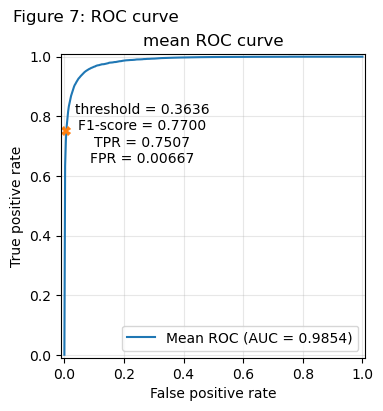

In [38]:
fig7 = plt.figure(figsize=(4, 4))
ax7 = fig7.add_axes((0.14, 0.11, 0.76, 0.76))

fig7.suptitle('Figure 7: ROC curve', x=0.02, ha='left')

ax7.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.4f})')
ax7.plot(thr_fpr, thr_tpr, marker='X', markersize=7, markeredgewidth=0.1)

ax7.legend(loc=4)
ax7.set_title('mean ROC curve')
ax7.set_xlabel('False positive rate')
ax7.set_ylabel('True positive rate')
ax7.set_xlim(-0.01, 1.01)
ax7.set_ylim(-0.01, 1.01)
ax7.grid(visible=True, alpha=0.3)

thr_txt = (f'threshold = {best_thr:.4f}\nF1-score = {best_score:.4f}\n'
           f'TPR = {thr_tpr:.4}\nFPR = {thr_fpr:.4}')
ax7.text(0.26, 0.74, thr_txt, ha='center', va='center')

plt.show()

We plot the ROC curve in figure 7. The location of our selected threshold is indicated on the curve as an orange cross. The AUC is 0.985, which indicates that the simple linear model is quite good.

### Model interpretation

The interpretation of a (scaled) linear model is simple: large coefficients correspond to more relevant features. However, since we did not drop the redundancy, only the relative difference is relevant for the categorical features coefficients.

In [39]:
# recover feature names
col_preproc = lr_model_ta.estimator_['column_preprocessing']
features = [feature_name.split('__')[1]
            for feature_name in col_preproc.get_feature_names_out()]

# get coefficients
intercept = lr_model_ta.estimator_['classifier'].intercept_[0]
coefs = lr_model_ta.estimator_['classifier'].coef_[0]


print(f'{"intercept":<20} : {intercept: }')
for feature, coef in zip(features, coefs):
    print(f'{feature:<20} : {coef: }')

intercept            : -4.017909617156093
country_China        : -3.5770088142514447
country_Germany      :  0.0185410988055964
country_UK           : -0.02742370448635039
country_US           : -0.38787295455814763
source_Ads           : -1.243933529781519
source_Direct        : -1.458803624662644
source_Seo           : -1.2710272200461803
new_user             : -1.7161011132168382
age                  : -0.6146494541189056
total_pages_visited  :  2.5301436409639932


The results follow closely what we saw in the EDA section:
- The most relevant variable is the total number of pages visited, having a positive correlation with the conversion probability;
- The age is negatively correlated with the conversion probability, yet with a 4 times lower influence than the number of pages visited;
- Being a new visitor penalizes the conversion probability;
- Similarly, coming from China causes a large penalty, while users from other countries have a rather uniform behavior;
- The visitors source has a limited effect (the coefficients are roughly the same).

#### Plotting decision boundaries

We will now plot decision boundaries for the various features. In doing so, we face two main difficulties:
- The coefficients must be brought back to the original scale
- The original feature space is more than 2-dimensional, hence we must aggregate the values in order for
  our decision boundaries to relate adequately to the plots of the EDA section.

We first un-scale the coefficients of quantitative variables.

In [40]:
# standard scaler coefs
qsc_means = col_preproc.transformers_[-1][1].mean_
qsc_scales = col_preproc.transformers_[-1][1].scale_

# un-scaled coefficients
unscaled_coefs = np.copy(coefs)
unscaled_coefs[-2:] /= qsc_scales
unscaled_intercept = intercept - np.sum(coefs[-2:] * qsc_means / qsc_scales)

# coefficients to be used for decision boundary computation
intercept = unscaled_intercept
coefs_dict = {f: c for f, c in zip(features, unscaled_coefs)}

The logit of the fitted conversion probability $p$ is:
$\mathrm{logit}(p) = c_0 + \sum_{k} c_k X_k$,

where the $c_k$ represent the unscaled coefficients.
The decision threshold at probability $p_0$ for a given (quantitative) variable $X_i$ given the values $X_k, k \neq i $ of the other features, is thus
$$X_i^{\mathrm{thr}} = \frac{\mathrm{logit}(p) - c_0 + \sum_{k \neq i} c_k X_k}{c_i}$$.

In order to display consistently the decision threshold on the plots made by aggregating different values $X_k$ of the features, we replace the value by the average over the dataset.

In [41]:
df_ = df.drop(['converted', 'total_pages_visited'], axis=1)
p_thr = best_thr

ctry_decision_thrs = {}
for group, gdf in df_.groupby('country'):
    decision_thr = logit(p_thr) - intercept
    for feature, mean in pd.get_dummies(gdf).mean().items():
        decision_thr -= coefs_dict[feature] * mean
    decision_thr /= coefs_dict['total_pages_visited']
    ctry_decision_thrs[group] = decision_thr

usr_decision_thrs = {}
for group, gdf in df_.groupby('new_user'):
    decision_thr = logit(p_thr) - intercept
    for feature, mean in pd.get_dummies(gdf).mean().items():
        decision_thr -= coefs_dict[feature] * mean
    decision_thr /= coefs_dict['total_pages_visited']
    usr_decision_thrs[group] = decision_thr

print(ctry_decision_thrs)
print(usr_decision_thrs)

{'China': 17.48547752589845, 'Germany': 12.665248600768765, 'UK': 12.72828239079138, 'US': 13.225040507156844}
{0: 12.54616203721192, 1: 14.90157094323227}


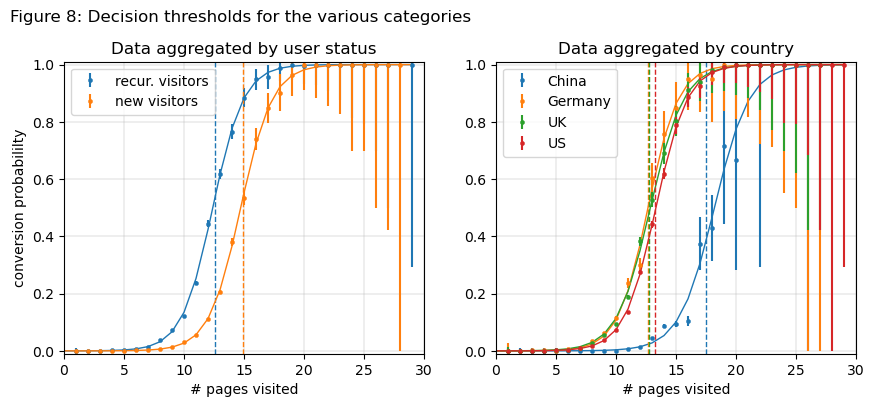

In [42]:
fig8, axs8 = plt.subplots(
    nrows=1, ncols=2, figsize=(9, 4),
    gridspec_kw={'left': 0.08, 'right': 0.96, 'top': 0.85, 'bottom': 0.12})

fig8.suptitle("Figure 8: Decision thresholds for the various categories",
              x=0.02, ha='left')

for ax in axs8:
    ax.grid(visible=True, linewidth=0.3)
    ax.set_xlim(0, 30)
    ax.set_ylim(-0.01, 1.01)
    ax.set_xlabel('# pages visited')

axs8[0].set_title('Data aggregated by user status')
axs8[0].set_ylabel('conversion probabililty')
for k, usr in enumerate(['recur. visitors', 'new visitors']):
    axs8[0].errorbar(
        npages, usr_npage_pconv[k], yerr=usr_npage_std_pconv[k],
        fmt='o', color=f'C{k}', markersize=3, markeredgewidth=0.3,
        label=f'{usr}')
    axs8[0].plot(npages, sigmoid(npages, *usr_popt[k]),
                 linewidth=1, color=f'C{k}')
    axs8[0].axvline(usr_decision_thrs[new_user[k]],
                    color=f'C{k}', linestyle='--', linewidth=1)
axs8[0].legend(loc=2)

axs8[1].set_title('Data aggregated by country')
for k, (key, val) in enumerate(ctry_decision_thrs.items()):
    axs8[1].errorbar(
        npages, ctry_npage_pconv[k], yerr=ctry_npage_std_pconv[k],
        fmt='o', color=f'C{k}', markersize=3, markeredgewidth=0.3,
        label=f'{key}')
    axs8[1].plot(npages, sigmoid(npages, *ctry_popt[k]),
                 linewidth=1, color=f'C{k}')
    axs8[1].axvline(val, color=f'C{k}', linestyle='--', linewidth=1)
axs8[1].legend(loc=2)

plt.show()

Figure 8 shows the conversion probability vs the number of pages visited for the various group of `'new_user'` (left panel) and `'country'` (right panel). The corresponding decision thresholds are shown as dashed vertical lines, and as in the EDA section, sigmoid fits are represented as solid lines. The thresholds are well postionned near the bayesian boundary at $p_{\mathrm{conv}} = 0.5$, except maybe for the data pertaining to chinese users. We thus expect that only minimal improvements of the F1 score can be obtained by fine tuning or with other models.

We proceed by computing the decision boundary in the plane of the quantitative variables `'age'` and `'total_pages_visited'`. In this case, the boundary for variables $X_i, X_j$ can be expressed as:
$$X_i^{\mathrm{thr}} = \frac{c_j}{c_i}X_j + \frac{\mathrm{logit}(p) - c_0 + \sum_{k \neq i, j} c_k X_k}{c_i}$$,
where, again, we replace the other feature $X_k, k \neq i, j$ by their average over the dataset.

In [43]:
df_ = df_.drop('age', axis=1)
##
dt_slope = - coefs_dict['age'] / coefs_dict['total_pages_visited']
dt_intercepts = {}
for group, gdf in df_.groupby('new_user'):
    dt_intercept = logit(p_thr) - intercept
    for feature, mean in pd.get_dummies(gdf).mean().items():
        dt_intercept -= coefs_dict[feature] * mean
    dt_intercept /= coefs_dict['total_pages_visited']
    dt_intercepts[group] = dt_intercept
print(f'decision boundary slope: {dt_slope}')
print(f'decision boundary intercepts: {dt_intercepts}')

decision boundary slope: 0.09824491665697059
decision boundary intercepts: {0: 9.557572570076065, 1: 11.89236973011559}


In [44]:
ages, npages = np.arange(81), np.arange(31)
new_user, counts, pconv, std_pconv = prob_distrib(
    df, group_by='new_user', variables=['total_pages_visited', 'age'],
    xvals=[npages, ages])
xx, yy = np.meshgrid(ages[17:]-0.5, npages-0.5)
x_dt = np.array([0, 80], dtype=float)

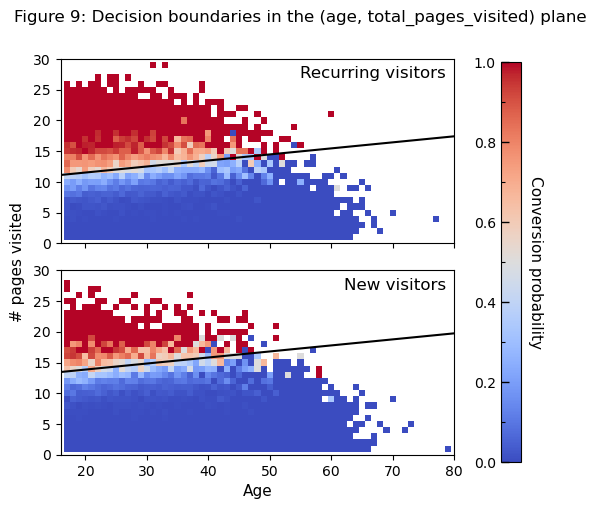

In [45]:
fig9, axs9 = plt.subplots(
    nrows=2, ncols=1, figsize=(5.5, 5.2),
    gridspec_kw={'left': 0.105, 'right': 0.82, 'top': 0.9, 'bottom': 0.11, 'hspace': 0.06})
cax9 = fig9.add_axes((0.905, 0.11, 0.036, 0.77))
fig9.suptitle('Figure 9: Decision boundaries in the (age, total_pages_visited) plane', x=0.02, ha='left')

for k, ax in enumerate(axs9):
    ax.set_aspect('equal')
    heatmap = ax.pcolormesh(
        xx, yy, pconv[k, :-1, 17:-1], cmap='coolwarm', vmin=0, vmax=1)
    ax.plot(x_dt, dt_intercepts[new_user[k]] + x_dt * dt_slope,
            color='k')
    ax.set_xlim(16, 80)
    ax.set_ylim(0, 30)

axs9[0].set_title("Recurring visitors", x=0.98, y=0.85, ha='right')
axs9[0].tick_params(bottom=True, labelbottom=False)
axs9[0].set_ylabel('# pages visited', y=-0.1, labelpad=6, fontsize=11)

axs9[1].set_title("New visitors", x=0.98, y=0.85, ha='right')
axs9[1].set_xlabel('Age', fontsize=11)

fig9.colorbar(heatmap, cax=cax9, orientation="vertical", ticklocation="left")
cax9.yaxis.set_label_position('right')
cax9.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9], minor=True)
cax9.set_ylabel('Conversion probability', labelpad=16, rotation=-90, fontsize=11)
cax9.tick_params(which='major', direction='in', length=6, width=1)
cax9.tick_params(which='minor', direction='in', length=3, width=0.8)

plt.show()

Figure 9 shows heatmaps of the conversion probability for recurring visitors (top panel) and new visitors (bottom panel), with the corresponding decision boundaries shown as solid black lines. Again, they go through the bayesian boundary $p_{\mathrm{conv}} = 0.5$ in both cases.

### Adding polynomial features

Although we saw that we can reasonably expect the decision boundary to be linear, we will now see if considering features correlations improves the model further.

#### Model construction

Scikit-learn provides a `preprocessing.PolynomialFeatures` to add polynomial features to the dataset. However, this class is not well adapted to our situation. We would like to include only a restricted set of polynomials features. Indeed, some of them are irrelevant, for instance the product of two one-hot encoded categorical variables is always zero. We therefore setup our custom `preprocessing.FunctionTransformer` to include the relevant polynomial features.

We choose to retain the L2 penalty rather than use the L1 penalty. The main reason of this choice is that the fitting times increases with solvers compatible with L1 penalty. Moreover, the polynomial feature engineering changes the feature counts from 10 to 48, which is still rather low in regard to the 300k observations.

In [46]:
# custom feature engineering
def poly_features_full(X: np.ndarray) -> np.ndarray:
    """
    Custom polynomial features construction:
        - Original features, Xi
        - 2nd order polynomials of quantitative features, Xi^2, Xi*Xj
        - Products of categorical and quantitative features, Xi_cat * Xj_quant
        - products of categorical variable from distinct parent features,
          eg Xi_country * Xj_source.
        
    This function is adapted to the *full* dataset preprocessed with one-hot
    encoding of the categorical variables 'country' and 'source'.
    """
    X_ = np.empty((len(X), 48), dtype=float)
    X_[:, :10] = X # original features
    
    X_[:, 10:12] = X[:, 8:10]**2 # age**2, npages**2
    X_[:, 12] = X[:, -2] * X[:, -1] # age * npages
    
    X_[:, 13:21] = X[:, :8] * X[:, [8]] # cat * age
    X_[:, 21:29] = X[:, :8] * X[:, [9]] # cat * npages
    
    X_[:, 29:36] = X[:, :7] * X[:, [7]] # new_user * [country, source]
    for i in range(4): # country * source
        X_[:, 36+3*i:36+3*(i+1)] = X[:, 4:7] * X[:, [i]]
    
    return X_

# classifier
lr = LogisticRegression(
    penalty='l2',
    C=0.1,
    fit_intercept=True,
    class_weight=None,
    solver='lbfgs',
    random_state=1234,
    )

# full pipeline
pipeline = Pipeline(
    [('column_preprocessing', col_preproc_full),
     ('poly_features', FunctionTransformer(poly_features_full)),
     ('classifier', lr)])

#### Model optimization, training and evaluation

Our approach to model training proceeds in three steps:
1.  Optimize the model hyperparameters,
2.  Evaluate the model by cross validation,
3.  Tune the decision threshold.

In [47]:
# optimize the regularization
best_C = gridsearch_cv(pipeline, X, y, 
                       param_name='C', param_vals=np.logspace(-3, -0, 16),
                       n_splits=10)
pipeline['classifier'].C = best_C

found best C: 0.25118864315095824


In [48]:
# evaluate by cross-validation
cm = cv_eval(pipeline, X, y)
print_metrics(cm)

Confusion matrix
 [[0.96397121 0.00377752]
 [0.01004645 0.02220481]]
Precision: 0.85461185; recall: 0.68849423
F1-score: 0.76261163


In [49]:
# adjujst threshold
lr_model_polyfeatures_ta = tune_threshold_cv(pipeline, X, y)

model fitting time: 15.179017543792725 s
best threshold = 0.41414346
best F1-score = 0.76977209


#### Model interpretation

To interpret the model's coefficients, we first need to keep track of the features names.

In [50]:
def poly_features_names(input_features)-> list[str]:
    """
    Names of the features produced by `poly_features_full`.
    """
    feature_names = [fn.split('__')[1] for fn in input_features]
    fns = feature_names + [f'{fn}^2' for fn in feature_names[-2:]] # age**2, npages**2
    fns += [f'{feature_names[-2]}_x_{feature_names[-1]}'] # age * npages
    fns += [f'{fn}_x_{feature_names[-2]}' for fn in feature_names[:-2]] # cat * age
    fns += [f'{fn}_x_{feature_names[-1]}' for fn in feature_names[:-2]] # cat * npages
    
    fns += [f'new_user_x_{fn}' for fn in feature_names[:-3]] # new_user * [country, source]
    for i in range(4):
        fns += [f'{feature_names[i]}_x_{fn}' for fn in feature_names[4:7]] # country*source
    return fns

In [51]:
features = poly_features_names(col_preproc_full.get_feature_names_out())
intercept = lr_model_polyfeatures_ta.estimator_['classifier'].intercept_[0]
coefs = lr_model_polyfeatures_ta.estimator_['classifier'].coef_[0]

print(f'{"intercept":<38} : {intercept: }')
for feature, coef in zip(features, coefs):
    print(f'{feature:<38} : {coef: }')

intercept                              : -3.8870931199634495
country_China                          : -2.277886909072978
country_Germany                        : -0.22285086228542222
country_UK                             : -0.34358697089663803
country_US                             : -0.5659896705243648
source_Ads                             : -1.0244231945792737
source_Direct                          : -1.2917036143968017
source_Seo                             : -1.0941876038033491
new_user                               : -0.9756333489123046
age                                    : -0.3922894380366093
total_pages_visited                    :  1.5121276785407283
age^2                                  :  0.028033754291861182
total_pages_visited^2                  :  0.029098012270083098
age_x_total_pages_visited              : -0.026867428726798998
country_China_x_age                    : -0.128844998537335
country_Germany_x_age                  : -0.07422891459878192
country_UK_x_age 

The model has not changed significantly. The polynomial features 'age'^2, 'total_pages_visited'^2, 'age' x 'total_pages visited' have a very low coefficient. The products with categorical variables from the same parent feature also have similar coefficients and therefore reveal no particular correlation either. 

This model is thus essentially equivalent to the simple linear model in terms of interpretation.

#### Evaluation on test data

In [52]:
print('===== Logistic regression : polynomial features and adjusted decision threshold =====')
_, cm = evaluate_model(lr_model_polyfeatures_ta)
print_metrics(cm)

===== Logistic regression : polynomial features and adjusted decision threshold =====
Confusion matrix
 [[0.96246047 0.00528147]
 [0.00907653 0.02318153]]
Precision: 0.81444444; recall: 0.71862745
F1-score: 0.76354167


With a F1 score of 0.7635, we conclude that this model expanded with polynomial features is also equivalent to the simple logistic regression in terms of performance, albeit at the cost of a 5-fold increased complexity.

However, this performance is obtained through more balanced precision and recall.

### Splitting the model

A final approach, backed by intuition, is to consider each `'country'` and `'new_user'` value as leading to a different behavior. We can thus split the dataset into
multiple datasets, corresponding to a (country, new_user) pair, and fit a different model on each one. The predictions will then be made by dispatching to the appropriate model.


#### Model construction

To build this model, we first split the dataset into a `dict`: group_index -> dataframe for each category $\mathrm{new_user} \times \mathrm{country}$.
We construct our split model as a `dict`: group_index -> pipeline, which we train on its corresponding dataset.

In [53]:
# split the dataset
groups = ['new_user', 'country']
Xs, ys = split_data(groups)

# column preprocessing
split_cat_vars = [v for v in cat_vars if v not in groups]
split_bool_vars = [v for v in bool_vars if v not in groups]
split_quant_vars = [v for v in quant_vars if v not in groups]
col_preproc_split = ColumnTransformer(
    [('cat_ohe', OneHotEncoder(drop=None), split_cat_vars),
     ('bool_id', FunctionTransformer(feature_names_out='one-to-one'), split_bool_vars),
     ('quant_scaler', StandardScaler(), split_quant_vars)])

# classifier
lr_split = LogisticRegression(
    penalty='l2',
    C=0.1,
    fit_intercept=True,
    class_weight=None,
    solver='lbfgs',
    random_state=1234,
)

# full pipeline
pipeline = Pipeline(
    [('column_preprocessing', col_preproc_split),
     ('classifier', lr_split)]
)
pipelines = {idx: clone(pipeline) for idx in Xs}

#### Model optimization, training and evaluation

In [54]:
# optimization
best_Cs = multimodel_gridsearch_cv(
    pipelines, Xs, ys, param_name='C', param_vals=np.logspace(-2, 0, 11))
for idx, pipeline in pipelines.items():
    pipeline['classifier'].C = best_Cs[idx]

(0, 'China') :: found best C: 0.15848931924611143
(0, 'Germany') :: found best C: 0.6309573444801934
(0, 'UK') :: found best C: 0.6309573444801934
(0, 'US') :: found best C: 1.0
(1, 'China') :: found best C: 0.15848931924611143
(1, 'Germany') :: found best C: 0.6309573444801934
(1, 'UK') :: found best C: 1.0
(1, 'US') :: found best C: 0.15848931924611143


In [55]:
# evaluation by cross validation
_ = multimodel_cv_eval(pipelines, Xs, ys, print_partial_scores=True)

===== Partial scores =====
== index: (0, 'China') ==
Precision: 0.8; recall: 0.21428571
F1-score: 0.33802817
== index: (0, 'Germany') ==
Precision: 0.87682672; recall: 0.79545455
F1-score: 0.83416087
== index: (0, 'UK') ==
Precision: 0.86486486; recall: 0.76864728
F1-score: 0.81392236
== index: (0, 'US') ==
Precision: 0.86372309; recall: 0.7419808
F1-score: 0.79823678
== index: (1, 'China') ==
Precision: 0.75; recall: 0.090909091
F1-score: 0.16216216
== index: (1, 'Germany') ==
Precision: 0.84057971; recall: 0.57711443
F1-score: 0.68436578
== index: (1, 'UK') ==
Precision: 0.812; recall: 0.57344633
F1-score: 0.67218543
== index: (1, 'US') ==
Precision: 0.82627119; recall: 0.54196776
F1-score: 0.65458207

===== Global scores =====
Confusion matrix
 [[0.96397473 0.00377401]
 [0.01005348 0.02219778]]
Precision: 0.85468813; recall: 0.68827631
F1-score: 0.7625083


Spliting the model into multiple components (new_user, country) reveals a strong heterogeneity in model performance:
- The F1-score is significantly higher in the datasets corresponding to recurring users, by about 0.14.
- The F1-score is significantly lower for datasets corresponding to chinese users, by about 0.5.
- The difficulties in our model predictions lie in the recall rather than the precision. Indeed the latter is always high (0.7 - 0.8), while recall can drop very low (down to 0.12 for new chinese visitors).
The model tends to have a low recall because shifting the decision threshold to increase it would introduce a lot of false positives due to the large imbalance between conversion and non-conversion events.

In [56]:
# decision threshold tuning
split_lr_model_ta = {}
for idx, p in pipelines.items():
    print(f'== {idx} ==')
    split_lr_model_ta[idx] = tune_threshold_cv(p, Xs[idx], ys[idx], verbose=True)

== (0, 'China') ==
model fitting time: 2.895561933517456 s
best threshold = 0.16148417
best F1-score = 0.46716440
== (0, 'Germany') ==
model fitting time: 2.301969289779663 s
best threshold = 0.48485953
best F1-score = 0.83767751
== (0, 'UK') ==
model fitting time: 2.582031726837158 s
best threshold = 0.46464963
best F1-score = 0.81900603
== (0, 'US') ==
model fitting time: 3.4326252937316895 s
best threshold = 0.43434899
best F1-score = 0.80303828
== (1, 'China') ==
model fitting time: 3.2050507068634033 s
best threshold = 0.14633546
best F1-score = 0.37047619
== (1, 'Germany') ==
model fitting time: 2.360996961593628 s
best threshold = 0.34342292
best F1-score = 0.72705100
== (1, 'UK') ==
model fitting time: 2.873002052307129 s
best threshold = 0.31312620
best F1-score = 0.70505724
== (1, 'US') ==
model fitting time: 4.799053907394409 s
best threshold = 0.34342718
best F1-score = 0.67030165


Tuning the decision thresholds seems to bring significant improvement, with again some noticeable heterogeneity in the optimized values. The best gains are seen for chinese users and new users.


#### Evaluation on test data

Our two models are `dict`s and as such do not have the `Estimator` interface (and most notably the `predict` method). To perform evaluation, we wrap our model in a class `MimicEstimator` which provides the sufficient interface for model evaluation on the test data.

In [57]:
print('===== Logistic regression : split model =====')
_, cm = evaluate_model(MimicEstimator(split_lr_model_ta, groups))
print_metrics(cm)

===== Logistic regression : split model =====
Confusion matrix
 [[0.96189121 0.00585073]
 [0.00888678 0.02337128]]
Precision: 0.79978355; recall: 0.7245098
F1-score: 0.76028807


The result is somewhat disappointing with a F1-score of 0.76. This possibly indicates that the splitting of the dataset into smaller ones caused some overfitting.

## <a id="lda"></a>Linear discriminant analysis

Linear discriminant analysis (LDA) provides another approach to linear classification. The idea is to assume that the conditional probabilities $P(X|\mathrm{no\ conversion})$ and $P(X|\mathrm{conversion})$ follow normal laws sharing the same covariance matrix. Although the two distributions are clearly not well represented by gaussian distributions, LDA is robust to such deviations to normality. In our case where we have clouds of points that can be well separated by a linear boundary, LDA is nevertheless a performant method.

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Full model

We begin by training the model on the full dataset, without the polynomial features.

#### Model construction

In [59]:
# classifier
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# pipeline
pipeline = Pipeline(
    [('column_preprocessing', col_preproc_full),
     ('classifier', lda)]
)

#### Model training and evaluation

We do not optimize the shrinkage parameter here, since the automatic shrinkage is good enough.

In [60]:
# evaluation by cross validation
cm = cv_eval(pipeline, X, y)
print_metrics(cm)

Confusion matrix
 [[0.9591641  0.00858464]
 [0.00760776 0.02464351]]
Precision: 0.74164552; recall: 0.76410983
F1-score: 0.7527101


Although the F1-score is no better than the logistic regression, it is interesting to note that it is obtained through balanced precxision and recall.

In [61]:
# decision threshold tuning
lda_model_ta = tune_threshold_cv(pipeline, X, y)

model fitting time: 8.82505202293396 s
best threshold = 0.60606061
best F1-score = 0.75892556


Tuning the threshold brings back the model toward higher precision and lower recall, but the F1-score is not improved significantly.

#### Evaluation on test data

In [62]:
print('===== Linear discriminant analysis : full model =====')
_, cm = evaluate_model(lda_model_ta)
print_metrics(cm)

===== Linear discriminant analysis : full model =====
Confusion matrix
 [[0.96100569 0.00673624]
 [0.00885515 0.02340291]]
Precision: 0.77649528; recall: 0.7254902
F1-score: 0.75012671


As expected, the F1-score is worse than logistic regression, but the precision and recall are nevertheless more balanced.